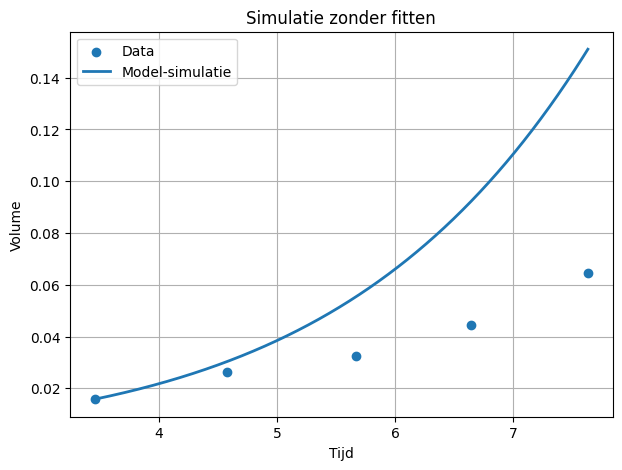

In [12]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from tumor_models import (
    GompertzPaperModel,
    GompertzLesModel,
    VonBertalanffyModel,
    RungeKutta4Solver,
)

# Jouw dataset
t_data = np.array([3.46, 4.58, 5.67, 6.64, 7.63])
V_data = np.array([0.0158, 0.0264, 0.0326, 0.0445, 0.0646])

# Kies een model
model = GompertzPaperModel(alpha=0.1, beta=0.05)

# Solve ODE zonder fitten
solver = RungeKutta4Solver(n_steps=2000)
ts, Vs = solver.solve(
    f=model.dVdt,
    V0=V_data[0],            # eerste gemeten volume
    t_end=max(t_data) - min(t_data)
)

# tijden opschuiven zodat ze bij de data passen
ts = np.array(ts) + t_data[0]

plt.figure(figsize=(7,5))
plt.scatter(t_data, V_data, label="Data")
plt.plot(ts, Vs, label="Model-simulatie", linewidth=2)
plt.legend()
plt.xlabel("Tijd")
plt.ylabel("Volume")
plt.title("Simulatie zonder fitten")
plt.grid(True)
plt.show()


In [ ]:
models = {
    "Gompertz (paper)": GompertzPaperModel(alpha=0.1, beta=0.05),
    "Gompertz (les)": GompertzLesModel(c=0.02, cap=8),
    "von Bertalanffy": VonBertalanffyModel(c=0.1, d=0.03),
}

solver = RungeKutta4Solver(n_steps=2000)

plt.figure(figsize=(8,6))
plt.scatter(t_data, V_data, color="black", s=50, label="Data")

for name, model in models.items():
    ts_sim, Vs_sim = solver.solve(model.dVdt, V0=V_data[0], t_end=max(t_data)-min(t_data))
    ts_sim = np.array(ts_sim) + t_data[0]
    plt.plot(ts_sim, Vs_sim, label=name)

plt.xlabel("Tijd")
plt.ylabel("Volume")
plt.title("Vergelijking van modellen (zonder fit)")
plt.grid(True)
plt.legend()
plt.show()



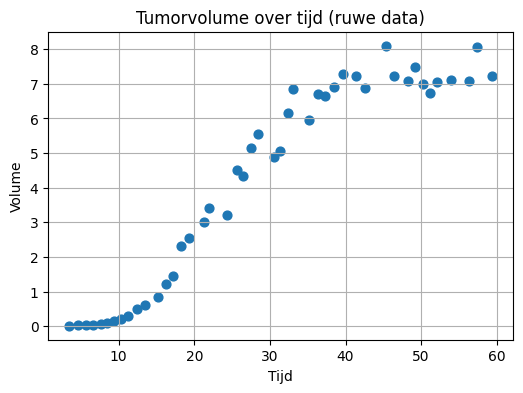

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(t_data, V_data, s=40)
plt.xlabel("Tijd")
plt.ylabel("Volume")
plt.title("Tumorvolume over tijd (ruwe data)")
plt.grid(True)
plt.show()


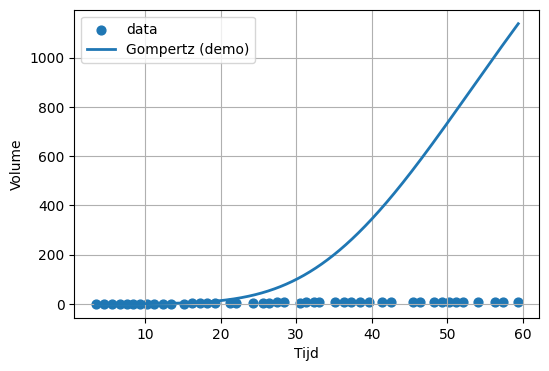

In [6]:
model_demo = GompertzPaperModel(alpha=0.1, beta=0.05)
solver = RungeKutta4Solver(n_steps=1000)

ts_sim, Vs_sim = solver.solve(
    f=model_demo.dVdt,
    V0=float(V_data[0]),   # beginvolume ~ eerste meting
    t_end=float(t_data[-1]) - float(t_data[0]),
)

# tijden even verschuiven zodat ze bij je data passen
ts_sim = np.array(ts_sim) + t_data[0]

plt.figure(figsize=(6, 4))
plt.scatter(t_data, V_data, s=40, label="data")
plt.plot(ts_sim, Vs_sim, label="Gompertz (demo)", linewidth=2)
plt.xlabel("Tijd")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
V0 = float(V_data[0])

models = {
    "Gompertz (paper)": (
        GompertzPaperModel(alpha=0.1, beta=0.01),
        {"alpha": (0.0, 1.0), "beta": (0.0, 0.2)},
    ),
    "Gompertz (les)": (
        GompertzLesModel(c=0.02, cap=8.0),
        {"c": (0.0, 0.1), "cap": (5.0, 20.0)},
    ),
    "von Bertalanffy": (
        VonBertalanffyModel(c=0.05, d=0.03),
        {"c": (0.0, 0.2), "d": (0.0, 0.1)},
    ),
}

results = {}


In [8]:
for name, (model, param_ranges) in models.items():
    print(f"Fitting {name} ...")
    fitter = ModelFitter(model=model, V0=V0)
    best_params, best_err = fitter.fit(
        t_data=list(t_data),
        V_data=list(V_data),
        param_ranges=param_ranges,
        n_iter=3000,  # hoger = betere fit, maar duurt langer
    )
    results[name] = {"params": best_params, "mse": best_err}
    print(f"  beste MSE = {best_err:.4g}, params = {best_params}")


Fitting Gompertz (paper) ...
  beste MSE = 1.232e+17, params = {'alpha': 0.575385551535997, 'beta': 0.17574527741649626}
Fitting Gompertz (les) ...
  beste MSE = 0.4618, params = {'c': 0.031823492943269464, 'cap': 7.304286632836787}
Fitting von Bertalanffy ...
  beste MSE = 6.202, params = {'c': 0.18486437081575358, 'd': 0.07334487109505634}


In [9]:
import pandas as pd

rows = []
for name, info in results.items():
    row = {"model": name, "MSE": info["mse"]}
    for p_name, p_val in info["params"].items():
        row[f"param_{p_name}"] = p_val
    rows.append(row)

df_results = pd.DataFrame(rows).sort_values("MSE")
df_results



,model,MSE,param_alpha,param_beta,param_c,param_cap,param_d
1,Gompertz (les),4.618461e-01,NaN,NaN,0.031823,7.304287,NaN
2,von Bertalanffy,6.201903e+00,NaN,NaN,0.184864,NaN,0.073345
0,Gompertz (paper),1.231904e+17,0.575386,0.175745,NaN,NaN,NaN


Best passend model: Gompertz (les) met params: {'c': 0.031823492943269464, 'cap': 7.304286632836787}


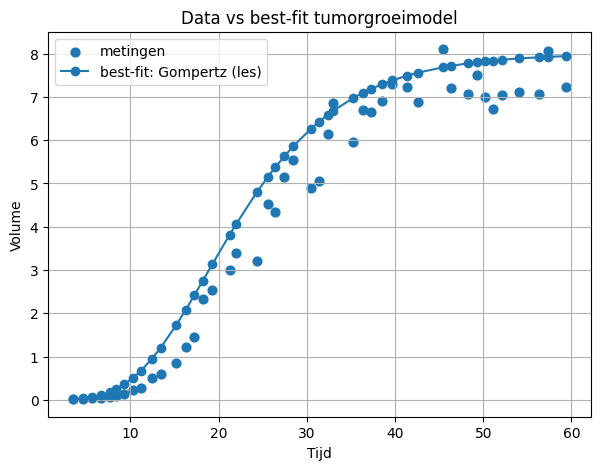

In [10]:
best_name = df_results.iloc[0]["model"]
best_model = models[best_name][0]  # model-object

print("Best passend model:", best_name, "met params:", best_model.params)

V_pred = simulate_and_interpolate(
    model=best_model,
    V0=V0,
    t_data=list(t_data),
    n_steps=2000,
)

plt.figure(figsize=(7, 5))
plt.scatter(t_data, V_data, s=40, label="metingen")
plt.plot(t_data, V_pred, "-o", label=f"best-fit: {best_name}")
plt.xlabel("Tijd")
plt.ylabel("Volume")
plt.title("Data vs best-fit tumorgroeimodel")
plt.grid(True)
plt.legend()
plt.show()



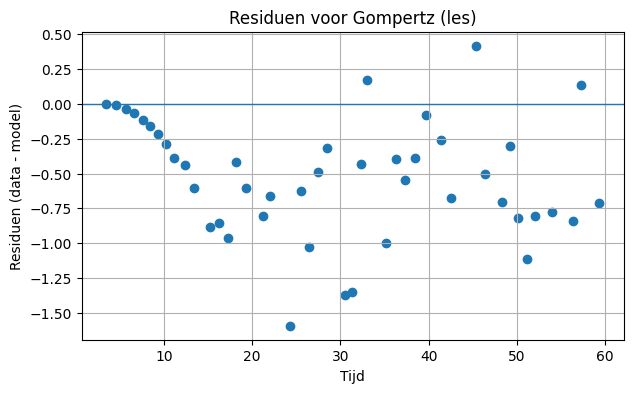

In [11]:
residuals = V_data - V_pred

plt.figure(figsize=(7, 4))
plt.axhline(0, linewidth=1)
plt.scatter(t_data, residuals)
plt.xlabel("Tijd")
plt.ylabel("Residuen (data - model)")
plt.title(f"Residuen voor {best_name}")
plt.grid(True)
plt.show()
